In [202]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [203]:
sns.set(rc={'figure.figsize':(15, 6)})

In [204]:
df = pd.read_csv('ml_project1_data.csv')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

# Tratamento de variáveis:
Income: tratar valores nulos -> tranformar em média, porque os dados são centralizados.

Year_Birth: transformar anos iniciados com '18' em '19' e substituir valor 1900 por média da variável

Marital_Status: transformar Alone, YOLO e Absurd em Others

In [206]:
def tratamento_variaveis(df):
    df['Income'].fillna(round(df['Income'].mean(), 2), inplace=True)
    df['Year_Birth'] = df['Year_Birth'].astype(str).replace(r'^18', '19', regex=True).astype(int)
    df['Year_Birth'].replace(1900, int(df['Year_Birth'].mean()), inplace=True)
    df['Marital_Status'].replace(['Alone', 'YOLO', 'Absurd'], 'Others', inplace=True)
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'])

In [207]:
tratamento_variaveis(df)

# Criação de variáveis

In [409]:
def criacao_variaveis(df):
    df['Age'] = 2021 - df['Year_Birth']
    df['TotalAccep'] = df.iloc[:, [20, 21, 22, 23, 24, 28]].sum(axis = 1, skipna = True)
    df['NumKidsHome'] = df['Kidhome'] + df['Teenhome']
    df['YearMonthCustomer'] = df['Dt_Customer'].dt.strftime('%Y-%m')
    df['YearCustomer'] = df['Dt_Customer'].dt.strftime('%Y')

In [410]:
criacao_variaveis(df)

In [210]:
def calculo_rfm(new_df):
    new_df['ID'] = df['ID']
    new_df['Recency'] = df['Recency']
    new_df['Frequency'] = df.iloc[:, 15:19].sum(axis = 1, skipna = True)
    new_df['TotalMnt'] = df.iloc[:, 9:15].sum(axis = 1, skipna = True)
    new_df['AvgMntperPurchase'] = round(new_df['TotalMnt'] / new_df['Frequency'], 0)
    new_df["RecencyScore"] = pd.cut(new_df["Recency"], 
                                bins=[-1, 
                                np.percentile(new_df["Recency"], 25), 
                                np.percentile(new_df["Recency"], 50), 
                                np.percentile(new_df["Recency"], 75), 
                                            new_df["Recency"].max()], 
                                labels=[4, 3, 2, 1]).astype("int")
    new_df["FrequencyScore"] = pd.cut(new_df["Frequency"], 
                                bins=[-1, 
                                np.percentile(new_df["Frequency"], 25), 
                                np.percentile(new_df["Frequency"], 50), 
                                np.percentile(new_df["Frequency"], 75), 
                                             new_df["Frequency"].max()], 
                                labels=[1, 2, 3, 4]).astype("int")
    new_df["MonetaryScore"] = pd.cut(new_df["TotalMnt"], 
                                bins=[-1, 
                                np.percentile(new_df["TotalMnt"], 25), 
                                np.percentile(new_df["TotalMnt"], 50), 
                                np.percentile(new_df["TotalMnt"], 75), 
                                             new_df["TotalMnt"].max()], 
                                labels=[1, 2, 3, 4]).astype("int")
    new_df['RFM'] = round((new_df["RecencyScore"] + new_df["FrequencyScore"] + new_df["MonetaryScore"]) / 3, 0)

df_rfm = pd.DataFrame()
calculo_rfm(df_rfm)

In [213]:
df = df.merge(df_rfm[['ID', 'Frequency', 'TotalMnt', 'RFM', 'AvgMntperPurchase']], on='ID', how='left')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Age,Frequency,TotalMnt,RFM,AvgMntperPurchase
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,0,0,3,11,1,64,25,1617,3.0,64.680000
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,0,0,3,11,0,67,6,27,2.0,4.500000
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,0,0,3,11,0,56,21,776,3.0,36.952381
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,0,0,3,11,0,37,8,53,2.0,6.625000
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,0,0,3,11,0,40,19,422,2.0,22.210526


# Análise exploratória de dados

# 1) Visão geral de vendas

Ao analisar os gastos dos clientes com diferentes segmentos de produtos, percebe-se que o segmento que mais gera receita são os vinhos. Ofertas que focam nesse segmento de produto podem apresentar melhores resultados. Também nota-se que há um maior número de pedidos em loja física que no site e um maior número de pedidos do catálogo que em produtos com desconto, o que pode significar que os clientes não estão tão preocupados com o preço do produto.

Os dados mostram que não há uma correlação significativa entre mais visitas ao site e compras mais recentes. Além disso, há uma correlação negativa entre mais visitas ao site e um maior gasto em compras. Portanto, o site pode ser analisado para repensar o funil de compras.

<AxesSubplot:title={'center':'Receita por segmento de produto'}>

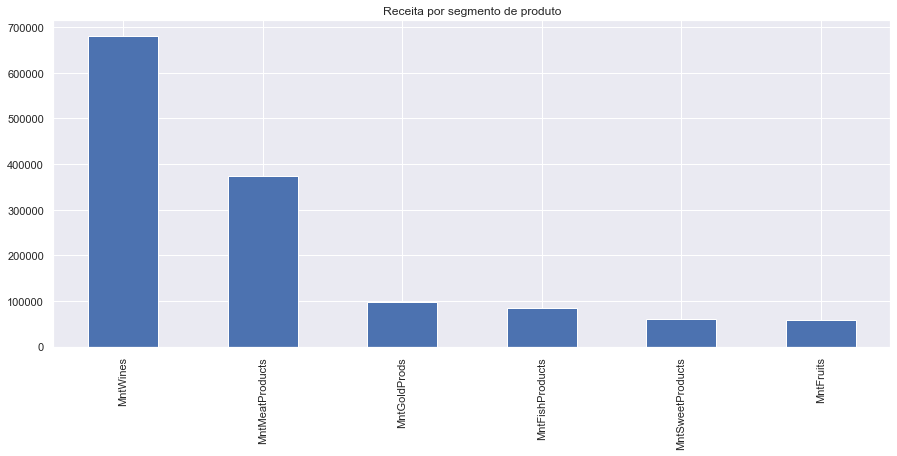

In [313]:
df.iloc[:, 9:15].sum().sort_values(ascending=False).plot.bar(title='Receita por segmento de produto')

Text(0.5, 1.0, 'Pedidos por catálogo X Pedidos promocionais')

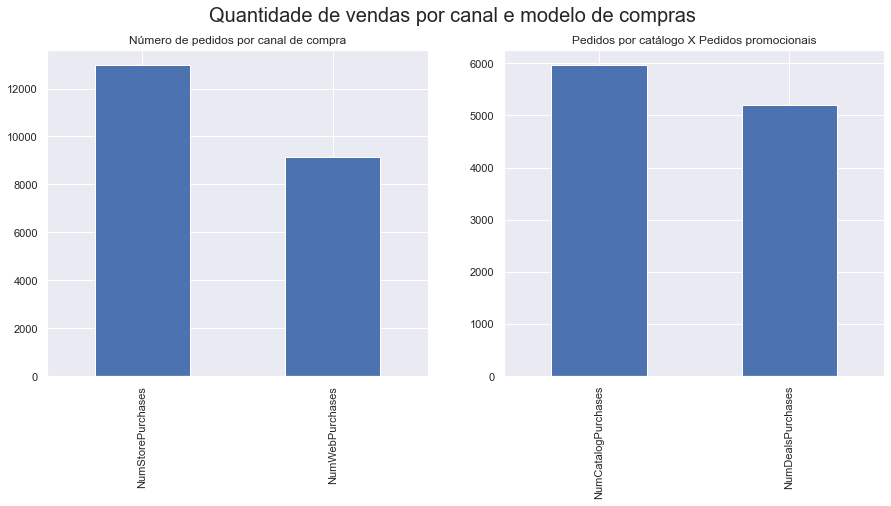

In [231]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
fig.suptitle("Quantidade de vendas por canal e modelo de compras", fontsize=20)

graph1 = df.loc[:, ['NumWebPurchases', 'NumStorePurchases']].sum().sort_values(ascending=False).plot.bar(ax=axes[0])
graph2 = df.loc[:, ['NumDealsPurchases', 'NumCatalogPurchases']].sum().sort_values(ascending=False).plot.bar(ax=axes[1])

graph1.set_title("Número de pedidos por canal de compra")
graph2.set_title("Pedidos por catálogo X Pedidos promocionais")

In [445]:
corr1 = df.loc[:, ['Recency', 'NumWebVisitsMonth']].corr()
corr2 = df.loc[:, ['TotalMnt', 'NumWebVisitsMonth']].corr()
print('Correlação entre visitas mensais ao site e recência de compras: ' + str(round(corr1['NumWebVisitsMonth']['Recency'], 2)))
print('Correlação entre visitas mensais ao site e total de gastos: ' + str(round(corr2['NumWebVisitsMonth']['TotalMnt'], 2)))

Correlação entre visitas mensais ao site e recência de compras: -0.02
Correlação entre visitas mensais ao site e total de gastos: -0.5


# 2) Dados demográficos do público selecionado

Os clientes selecionados tem renda anual de até 163 mil (excluindo um outlier de 666 mil). Além disso, a maioria dos clientes tem nível de escolaridade de no mínimo graduação, estão em um casamento ou união estável e tem entre 0 e 1 filhos em casa.

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Income'}>]], dtype=object)

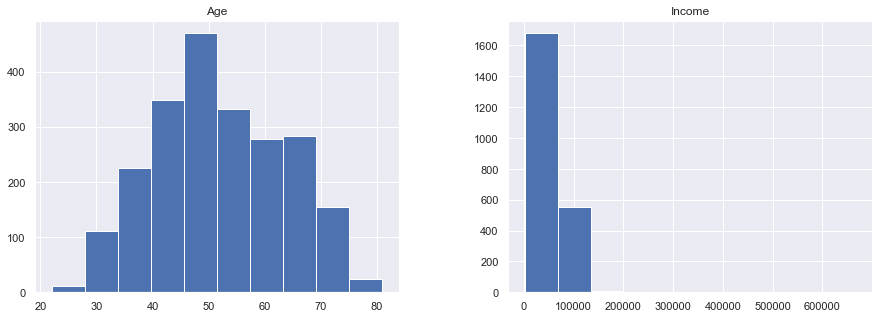

In [354]:
sns.set(rc={'figure.figsize':(15, 5)})
df.loc[:, ['Age', 'Income']].hist()

<AxesSubplot:xlabel='NumKidsHome'>

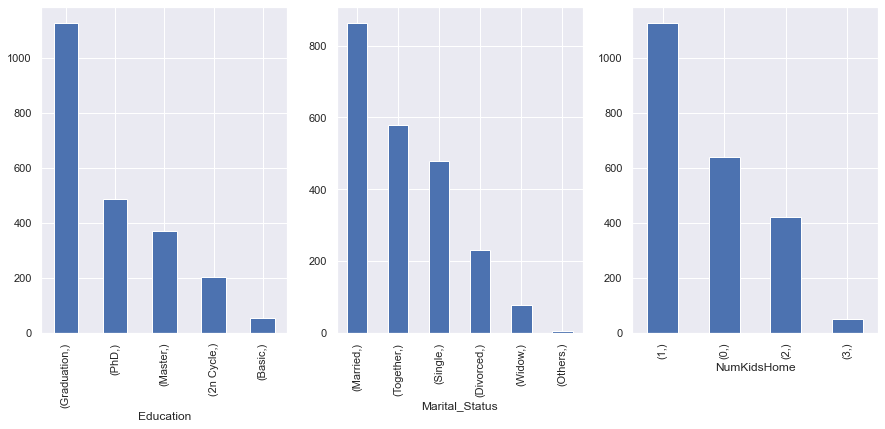

In [359]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,6))

df.loc[:, ['Education']].value_counts().plot.bar(ax=axes[0])
df.loc[:, ['Marital_Status']].value_counts().plot.bar(ax=axes[1])
df.loc[:, ['NumKidsHome']].value_counts().plot.bar(ax=axes[2])

# 3) Análise de campanhas

Para analisar o histórico das campanhas, criou-se uma variável TotalAccep, que representa o número de ofertas aceitas pelo cliente (incluindo aceites da campanha pioto). Além disso, separou-se os clientes em dois grupos: clientes que não aceitaram nenhuma das ofertas e clientes que aceitaram pelo menos uma das ofertas.

Percebe-se que as últimas três campanhas e o piloto tiveram um maior número de aceites, o que é uma boa tendência de melhoria das campanhas. Existe uma correlação positiva entre o número total de ofertas aceitas e o score RFM dos clientes (principalmente nas variáveis frequência e total gasto). Também há uma correlação positiva entre o total de ofertas e a renda do cliente. Também há uma correlação positiva entre o total de ofertas aceitas e o número de compras pela internet e pelo catálogo.

Os gráficos também corroboram com o fato de que parece haver uma correlação positiva entre ofertas aceitas e score RFM e renda do cliente. Esses indícios serão investigados mais a fundo no próximo tópico.

Por fim, é interessante notar que clientes mais antigos aderiram mais a pelo menos uma oferta.

<AxesSubplot:title={'center':'Número de ofertas aceitas por campanha'}>

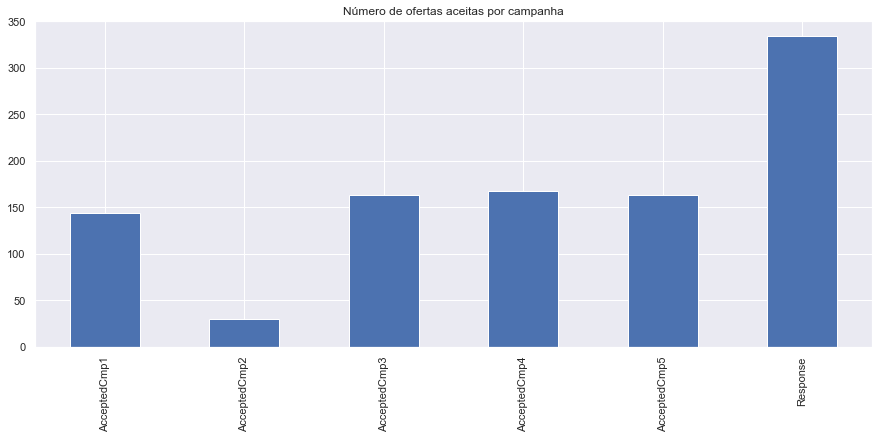

In [315]:
df.loc[:, ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].sum().plot.bar(title='Número de ofertas aceitas por campanha')

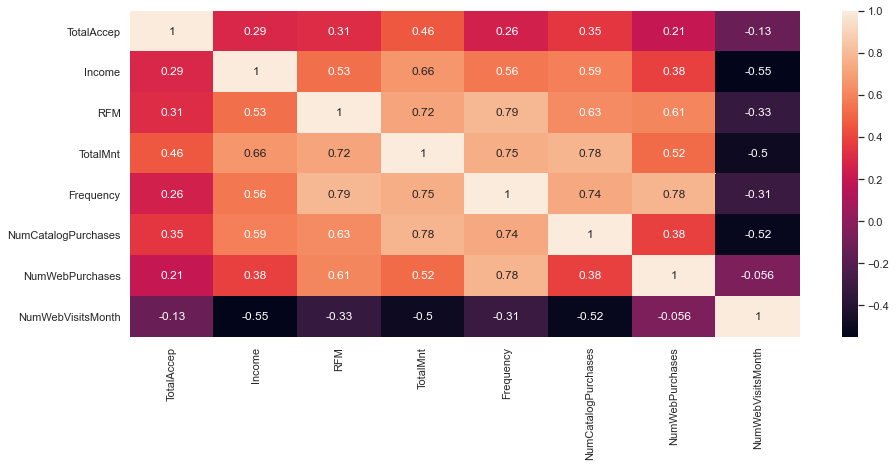

In [364]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.loc[:, ['TotalAccep', 'Income', 'RFM', 'TotalMnt', 'Frequency', 'NumCatalogPurchases', 'NumWebPurchases', 'NumWebVisitsMonth']].corr(), annot=True, cmap='rocket')
plt.show()

Text(0.5, 1.0, 'Participantes que não aceitaram nenhuma oferta')

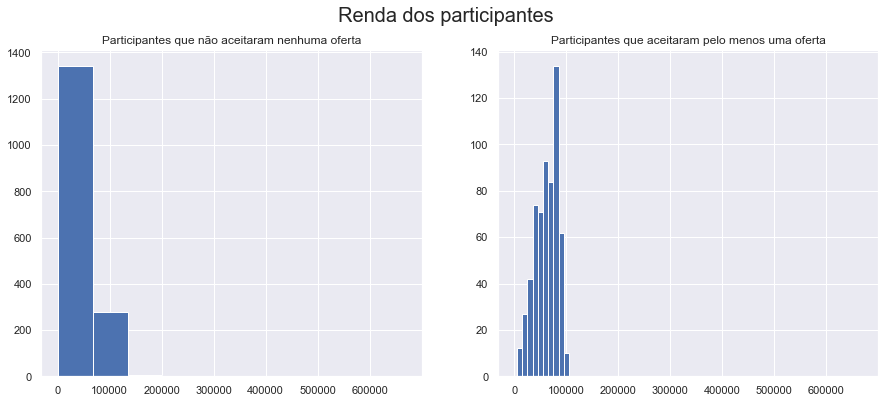

In [387]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=True)
fig.suptitle("Renda dos participantes", fontsize=20)
hist1 = df.loc[(df.TotalAccep == 0), 'Income'].hist(ax=axes[0])
hist2 = df.loc[(df.TotalAccep != 0), 'Income'].hist(ax=axes[1])
hist2.set_title('Participantes que aceitaram pelo menos uma oferta')
hist1.set_title('Participantes que não aceitaram nenhuma oferta')

Text(0.5, 1.0, 'Participantes que aceitaram pelo menos uma oferta')

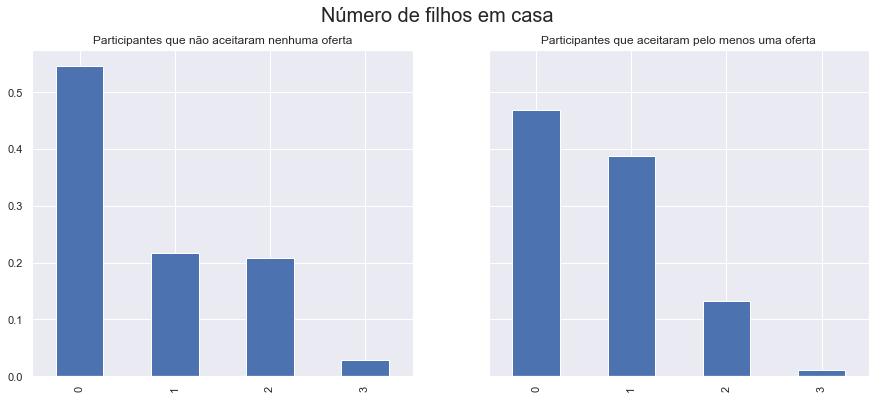

In [392]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=True, sharey=True)
fig.suptitle("Número de filhos em casa", fontsize=20)
graph1 = df.loc[(df.TotalAccep == 0), 'NumKidsHome'].value_counts(normalize=True).plot.bar(ax=axes[0])
graph2 = df.loc[(df.TotalAccep != 0), 'NumKidsHome'].value_counts(normalize=True).plot.bar(ax=axes[1])
graph1.set_title('Participantes que não aceitaram nenhuma oferta')
graph2.set_title('Participantes que aceitaram pelo menos uma oferta')

Text(0.5, 1.0, 'Participantes que aceitaram pelo menos uma oferta')

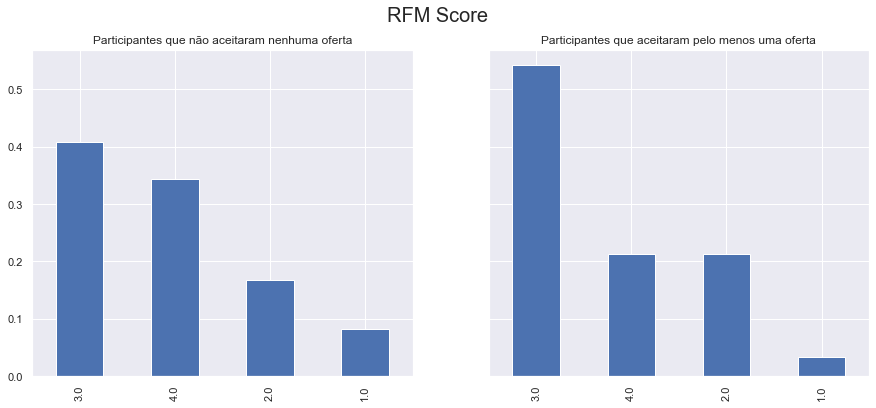

In [393]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharex=True, sharey=True)
fig.suptitle('RFM Score', fontsize=20)
graph1 = df.loc[(df.TotalAccep == 0), 'RFM'].value_counts(normalize=True).plot.bar(ax=axes[0])
graph2 = df.loc[(df.TotalAccep != 0), 'RFM'].value_counts(normalize=True).plot.bar(ax=axes[1])
graph1.set_title('Participantes que não aceitaram nenhuma oferta')
graph2.set_title('Participantes que aceitaram pelo menos uma oferta')

In [424]:
histCustomer = df.loc[:, ['YearCustomer', 'Recency', 'Response']][(df.Response == 1)].groupby('YearCustomer')
histCustomer['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
YearCustomer,,,,,,,,
2012,132.0,41.348485,27.798892,1.0,15.00,40.0,60.00,99.0
2013,154.0,34.759740,28.069721,0.0,11.00,26.5,60.00,98.0
2014,48.0,20.979167,19.711202,0.0,4.75,16.0,30.25,81.0


In [522]:
histCustomer = df.loc[:, ['YearCustomer', 'Recency', 'Response']][(df.Response == 0)].groupby('YearCustomer')
histCustomer['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
YearCustomer,,,,,,,,
2012,362.0,53.215470,29.275802,0.0,29.0,55.0,78.75,99.0
2013,1035.0,51.470531,28.229336,0.0,28.0,52.0,75.50,99.0
2014,509.0,50.394892,28.558878,0.0,26.0,50.0,76.00,99.0


# 4) Segmentação de clientes por RFM

A segmentação dos clientes pelo score RFM (explicar o que significa na parte do cálculo) permite concluir que os clientes com score 3 e 4 aderiram significativamente mais à campanha piloto. Isso significa que os clientes com esses score tem maior probabilidade de aderir à oferta.

Ao analisar dados demográficos e comportamento de consumo, percebe-se que há correlações positivas entre o aumento do score RFM e a renda do cliente, assim como com a média de gastos por compra do mesmo. Portanto, clientes com maior renda e com uma maior média de gastos por compra tem maior probabilidade de terem altos score RFM. Os clientes com maior renda também tendem a ter um montante de gastos maior na loja.
Também nota-se uma correlação negativa entre o aumento do score e o número de filhos em casa, o que faz sentido ao pensar que clientes com menos filhos podem ter parte maior da renda destinada a gastos supérfluos (mudar termo). 

Ao verificar os dados demográficos para cada score RFM, observa-se que clientes com score 3 e 4 tendem a possuir graus mais altos de escolaridade e clientes de score 3 estão em sua maioria casados ou em união estável. Não se percebe variações de faixa etária nos diferentes score (trocar score para ranking? colocar porcentagem nos gráficos de barra stacked?).

# 4.1) RFM e aceite de oferta piloto

<AxesSubplot:ylabel='Response'>

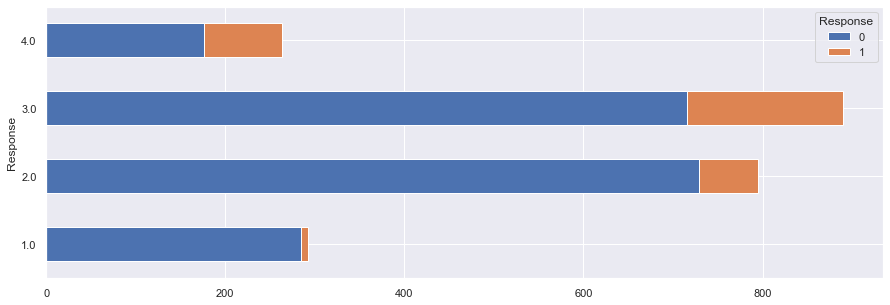

In [506]:
df_edu_rfm = df.loc[:, ['Response', 'RFM']]
df_grouped = df_edu_rfm.groupby(['Response', 'RFM']).agg(count=('Response', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='Response', values='count')
df_pivot.plot.barh(xlabel='Response', stacked=True)

In [516]:
df_pivot['No %'] = df_pivot[0] / (df_pivot[0] + df_pivot[1])
df_pivot['Yes %'] = df_pivot[1] / (df_pivot[0] + df_pivot[1])
df_pivot

Response,0,1,No %,Yes %
RFM,,,,
1.0,285,7,0.976027,0.023973
2.0,729,66,0.916981,0.083019
3.0,716,174,0.804494,0.195506
4.0,176,87,0.669202,0.330798


# 4.2) RFM, renda e gastos

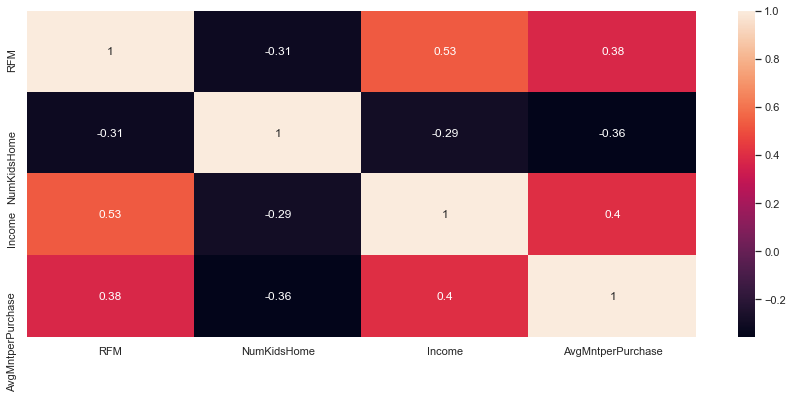

In [447]:
plt.figure(figsize=(15, 6))
sns.heatmap(df.loc[:, ['RFM', 'NumKidsHome', 'Income', 'AvgMntperPurchase']].corr(), annot=True, cmap='rocket')
plt.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


Correlação entre renda e total de gastos: 0.66


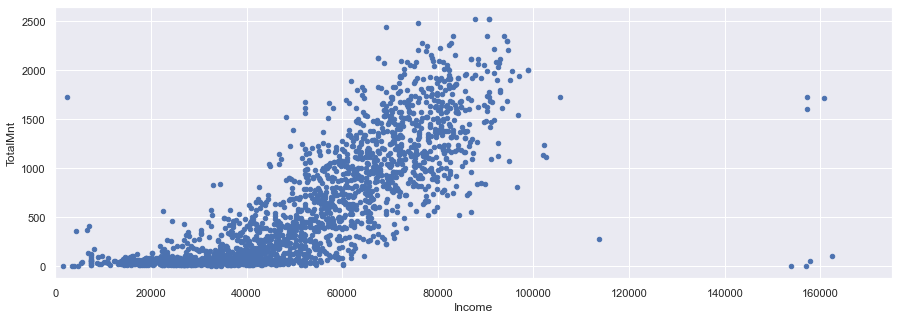

In [440]:
incomeSpendingGraph = df.plot.scatter(x='Income', y='TotalMnt')
incomeSpendingGraph.set_xlim(0, 175000)
incomeSpendingcorr = df.loc[:, ['Income', 'TotalMnt']].corr()
print('Correlação entre renda e total de gastos: ' + str(round(incomeSpendingcorr['TotalMnt']['Income'], 2)))

# 4.3) RFM por dados demográficos

array([[<AxesSubplot:title={'center':'1.0'}>,
        <AxesSubplot:title={'center':'2.0'}>],
       [<AxesSubplot:title={'center':'3.0'}>,
        <AxesSubplot:title={'center':'4.0'}>]], dtype=object)

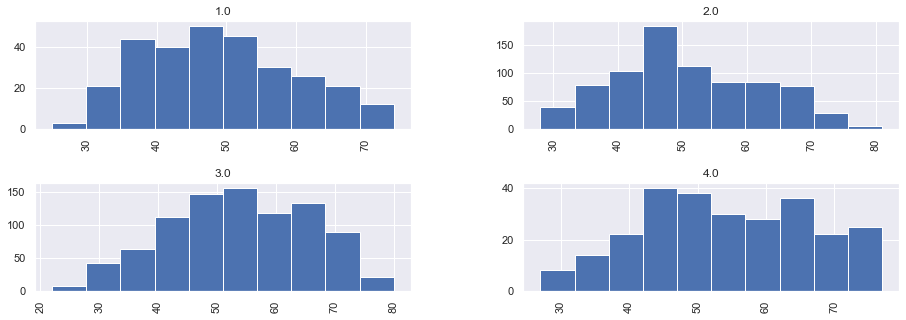

In [454]:
df.hist(column='Age', by='RFM')

<AxesSubplot:xlabel='Education'>

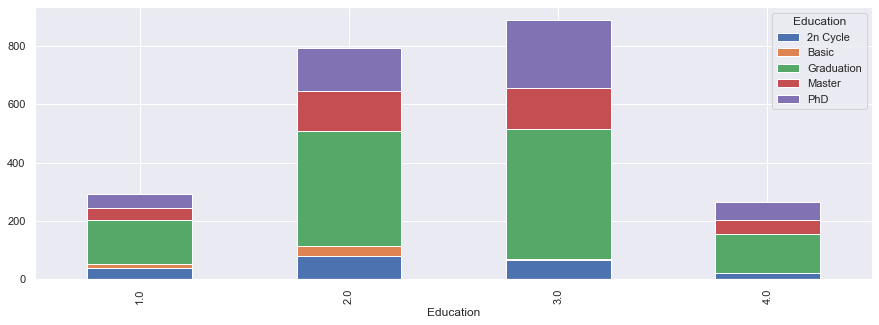

In [492]:
df_edu_rfm = df.loc[:, ['Education', 'RFM']]
df_grouped = df_edu_rfm.groupby(['Education', 'RFM']).agg(count=('Education', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='Education', values='count')
df_pivot.plot.bar(xlabel='Education', stacked=True)

<AxesSubplot:xlabel='Marital Status'>

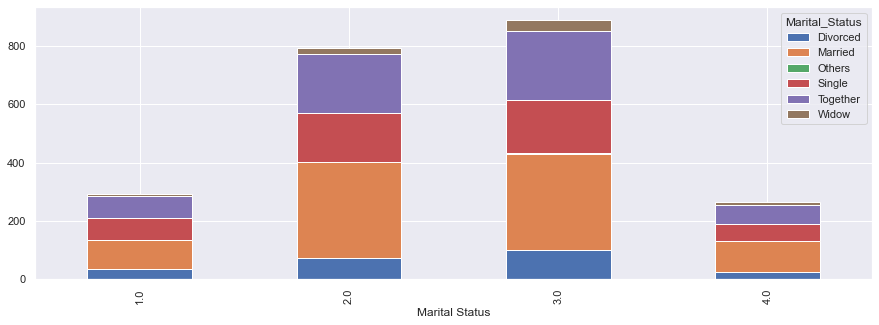

In [493]:
df_edu_rfm = df.loc[:, ['Marital_Status', 'RFM']]
df_grouped = df_edu_rfm.groupby(['Marital_Status', 'RFM']).agg(count=('Marital_Status', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='Marital_Status', values='count')
df_pivot.plot.bar(xlabel='Marital Status', stacked=True)

<AxesSubplot:xlabel='Number of Kids at Home'>

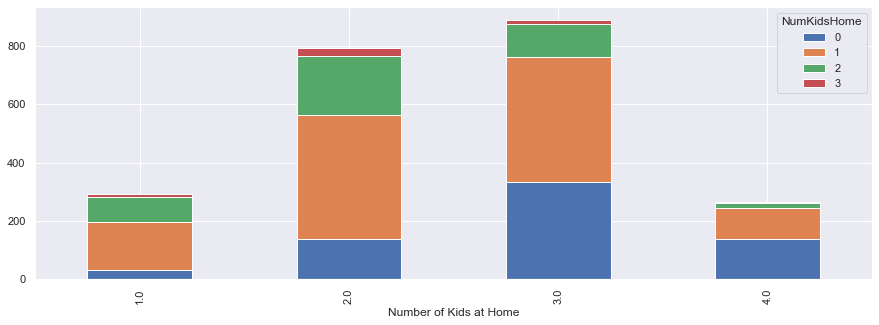

In [494]:
df_edu_rfm = df.loc[:, ['NumKidsHome', 'RFM']]
df_grouped = df_edu_rfm.groupby(['NumKidsHome', 'RFM']).agg(count=('NumKidsHome', 'count')).reset_index()
df_pivot = df_grouped.pivot(index='RFM', columns='NumKidsHome', values='count')
df_pivot.plot.bar(xlabel='Number of Kids at Home', stacked=True)